In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
yolo = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
classes = []

In [3]:
with open("coco.names", "r") as file:
    classes = [line.strip() for line in file.readlines()]

In [4]:
# generate different colors for different classes 
colors = np.random.uniform(0, 255, size=(len(classes), 3))

In [5]:
colors.astype(int)

array([[108, 222,  74],
       [ 29, 200, 149],
       [ 86,  34, 150],
       [105, 191,  30],
       [181,  75, 186],
       [111,  53, 170],
       [171, 159, 230],
       [ 41, 103,  38],
       [ 40, 193,  40],
       [ 69, 139, 107],
       [ 31, 153,  44],
       [135,  94, 102],
       [154,  54, 156],
       [186, 206, 146],
       [ 92, 129, 103],
       [  3, 149,  20],
       [208,  20,   1],
       [ 90, 210,  56],
       [218, 148, 157],
       [135, 233,   3],
       [ 16, 196, 181],
       [172, 204,  61],
       [  2, 219,  55],
       [163, 127,  12],
       [165,   4,   0],
       [ 54, 216,  99],
       [107,  18, 105],
       [ 61,  70, 225],
       [  4,  86, 188],
       [183, 146, 155],
       [181,  65,  98],
       [236, 164, 148],
       [150, 209, 247],
       [ 23,  85, 131],
       [180, 251, 108],
       [229, 140,   9],
       [ 63, 122, 201],
       [ 16,   1, 226],
       [188, 194, 170],
       [135,  86, 248],
       [ 61,   8, 200],
       [ 93, 237

In [6]:
len(colors)

80

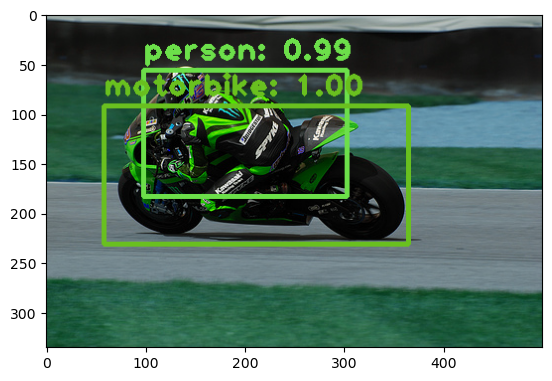

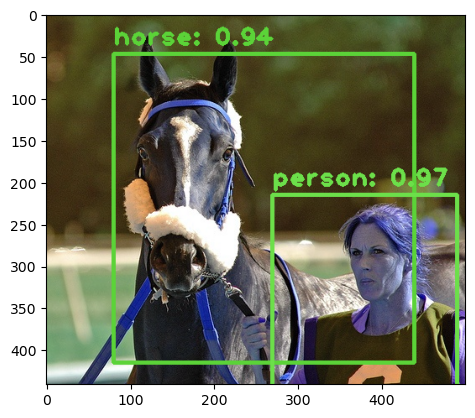

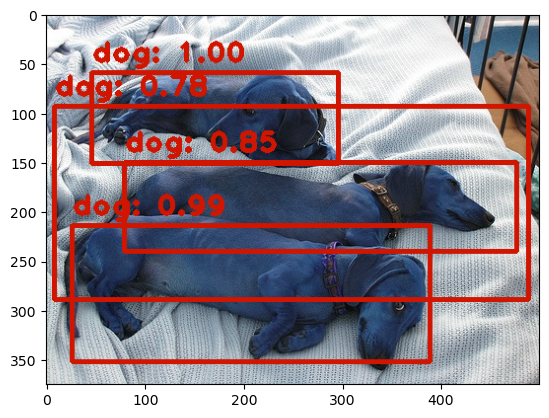

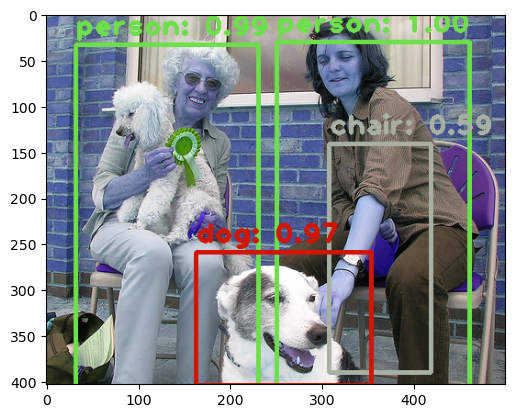

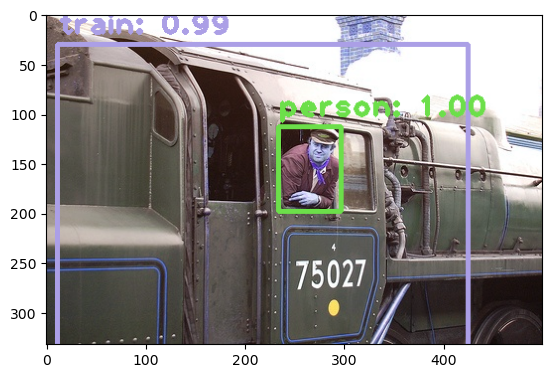

In [11]:
# #Loading Images
names = ["2009_000730.jpg","2007_000799.jpg","2007_002852.jpg","2010_003894.jpg","2007_009950.jpg"]
for name in names:
    img = cv2.imread(name)
    height, width, channels = img.shape
    
    # create input blob 
    scale = 0.00392
    blob = cv2.dnn.blobFromImage(img, scale, (416,416), (0,0,0), True, crop=False)
    
    output_layers_indices = yolo.getUnconnectedOutLayers()
    
    # get the output layer names in the architecture
    layer_names = yolo.getLayerNames()
    output_layers = [layer_names[i - 1] for i in yolo.getUnconnectedOutLayers()]
    
    
    # set input blob for the network
    yolo.setInput(blob)

    # run inference through the network and gather predictions from output layers
    outputs = yolo.forward(output_layers)
    
    
    # for each detetion from each output layer, get the confidence, class id, bounding box params
    # and ignore weak detections (confidence < 0.5)

    class_ids = []
    confidences = []
    boxes = []
    for output in outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    
    conf_threshold, nms_threshold = 0.5, 0.4
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            #print(class_ids[i])
            label = str(classes[class_ids[i]])
            confidence = confidences[i]  # Confidence score
            text = f"{label}: {confidence:.2f}"  # Text with label and confidence score

            # Ensure text position is within the image boundaries
            text_width, text_height = cv2.getTextSize(text, cv2.FONT_HERSHEY_PLAIN, 2, thickness=4)[0]
            if x + text_width > img.shape[1]:
                x = img.shape[1] - text_width - 10
            if y - text_height < 0:
                y = text_height + 10
            
            cv2.rectangle(img, (x, y), (x + w, y + h), colors[class_ids[i]], 3)
            cv2.putText(img, text, (x, y - 10), cv2.FONT_HERSHEY_PLAIN, 2, colors[class_ids[i]], 4)
            #cv2.putText(img, label, (x, y + 10), cv2.FONT_HERSHEY_PLAIN, 3, colors[class_ids[i]], 4)
            
    # display output image    
    plt.imshow(img)
    plt.show()

    
     # save output image to disk
    cv2.imwrite(f"obj_det_image_{name}.jpg", img)
    